In [1]:
import numpy as np
import pandas as pd
import time
import tifffile as tiff
import matplotlib.pyplot as plt
from skimage.io import imread

# Image Processing pipeline

We now know how to select and transfer data towards our device, let's apply some processing on it.

We will use a classic image processing pipeline: `blur > threshold > label > quantify`

### CPU - skimage pipeline

Processing time: 0.021280288696289062 seconds


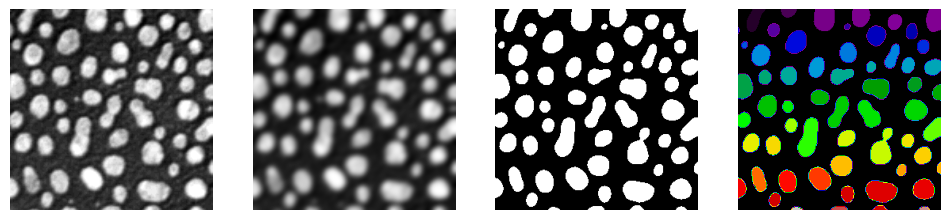

,label,area,centroid-0,centroid-1,bbox-0,bbox-1,bbox-2,bbox-3,eccentricity,solidity,orientation,major_axis_length,minor_axis_length,min_intensity,max_intensity,mean_intensity,std_intensity
0,1,421.0,12.881235,20.147268,0,11,29,35,0.875730,0.921225,-0.434905,34.186917,16.505461,104.0,232.0,192.285036,29.571677
1,2,173.0,4.144509,63.132948,0,54,11,74,0.822739,0.966480,-1.513044,20.213669,11.489826,136.0,224.0,182.473988,18.753825
2,3,661.0,12.529501,108.473525,0,95,28,122,0.357974,0.976366,-0.149729,30.338524,28.328037,120.0,248.0,205.155825,30.042153
3,4,444.0,9.887387,154.259009,0,144,23,167,0.381000,0.971554,-0.633719,25.017761,23.130792,96.0,248.0,214.846847,39.182226
4,5,481.0,13.480249,246.767152,0,237,29,256,0.766926,0.975659,-0.025610,31.185763,20.013006,104.0,248.0,211.276507,31.213443


In [2]:
from skimage.filters import gaussian, threshold_otsu
from skimage.measure import label, regionprops_table

image = imread('https://samples.fiji.sc/blobs.png').squeeze()

start = time.time()
blurred_image = gaussian(image, sigma=3)
binary_image = blurred_image > threshold_otsu(blurred_image)
labeled_image = label(binary_image)
props = regionprops_table(labeled_image, intensity_image=image, properties=
                          ['label', 'area', 'centroid', 'bbox', 'eccentricity', 'solidity', 'orientation', 'major_axis_length', 'minor_axis_length', 
                           'min_intensity', 'max_intensity', 'mean_intensity', 'std_intensity'])
print(f"Processing time: {time.time() - start} seconds")

fig, axs = plt.subplots(1, 4, figsize=(12, 6))
axs[0].imshow(image, cmap='gray')
axs[1].imshow(blurred_image, cmap='gray')
axs[2].imshow(binary_image, cmap='gray')
axs[3].imshow(labeled_image, cmap='nipy_spectral')
for ax in axs:
    ax.axis('off')
plt.show()

pd.DataFrame(props).head()

### GPU - clesperanto pipeline

Applying the same pipeline, this time using clesperanto. Naming are not exactly the same as we try to stick to wordy but clear operation name.

However, the API follow a specific pattern:

> output = cle.operation_name(input, output, args)

where:

- `cle` is the librairy handle
- `operation_name` is the name of the operation you want to apply
- `input` is the input data
- `output` is the output data
- `args` are the parameters of the operation (none, one, or more, generaly with default values)

If the `output` array is provided, the library will use it as it is. If left to `None`, the library will automatically create it on the device and return it.
In most usage, we will use the return `output` as it is easier but providing yourself the `output` variable allows you to have a more refine control on the device memory and output.

Each functions are documented, you can access though your IDE or using the `cle.operation_name?` idiom un notebook, or use the [Documentation](https://clesperanto-doc.readthedocs.io)

Processing time: 0.01986217498779297 seconds


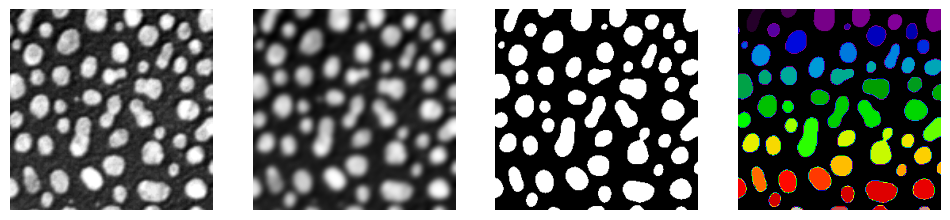

,max_distance_to_mass_center,mean_distance_to_centroid,mean_distance_to_mass_center,sum_distance_to_centroid,centroid_y,max_distance_to_centroid,sum_y,centroid_x,mass_center_z,mass_center_y,...,sum_distance_to_mass_center,bbox_depth,bbox_max_y,centroid_z,bbox_max_z,bbox_max_x,bbox_min_z,bbox_min_y,bbox_min_x,label
0,18.989819,8.673912,8.672676,3651.716797,12.881236,18.916245,5423.0,20.147270,0.0,12.918570,...,3651.196533,1.0,28.0,0.0,0.0,34.0,0.0,0.0,11.0,1.0
1,10.554322,5.353654,5.357302,926.182129,4.144508,10.702135,717.0,63.132946,0.0,4.084643,...,926.813293,1.0,10.0,0.0,0.0,73.0,0.0,0.0,54.0,2.0
2,16.960754,9.759805,9.760290,6460.990723,12.531722,17.041229,8296.0,108.453171,0.0,12.461044,...,6461.312012,1.0,27.0,0.0,0.0,121.0,0.0,0.0,95.0,3.0
3,13.708274,8.011743,8.014387,3565.225586,9.898876,13.904107,4405.0,154.235962,0.0,9.688731,...,3566.402344,1.0,22.0,0.0,0.0,166.0,0.0,0.0,144.0,4.0
4,15.260367,8.624294,8.637898,4148.285645,13.480249,15.795471,6484.0,246.767151,0.0,13.061402,...,4154.829102,1.0,28.0,0.0,0.0,255.0,0.0,0.0,237.0,5.0


In [3]:
import pyclesperanto as cle
cle.select_device(1, device_type='gpu')

image = imread('https://samples.fiji.sc/blobs.png').squeeze()

start = time.time()
gpu_img = cle.push(image)
blurred_image = cle.gaussian_blur(gpu_img, sigma_x=3, sigma_y=3)
binary_image = cle.threshold_otsu(blurred_image)
labeled_image = cle.connected_component_labeling(binary_image)
props = cle.statistics_of_labelled_pixels(label=labeled_image, intensity=gpu_img)
print(f"Processing time: {time.time() - start} seconds")

fig, axs = plt.subplots(1, 4, figsize=(12, 6))
axs[0].imshow(gpu_img, cmap='gray')
axs[1].imshow(blurred_image, cmap='gray')
axs[2].imshow(binary_image, cmap='gray')
axs[3].imshow(labeled_image, cmap='nipy_spectral')
for ax in axs:
    ax.axis('off')
plt.show()

pd.DataFrame(props).head()

### GPU - cupy pipeline

Cupy is not an __image processing__ package, it comes with a large set of operation from the `ndimage` module from __scipy__ which allows us to perform several operation right on images but we still need to rely on some of the __scikit-image__ package.

> [NOTE]
> Not all operation can be performed on GPU, __cupy__ or __clesperanto__ are not replacement package for __scikit-image__ !

Processing time: 0.015683889389038086 seconds


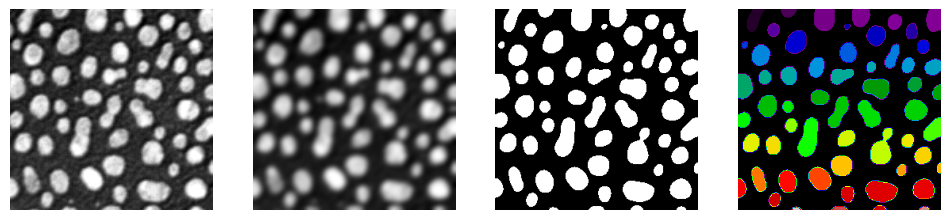

,label,area,centroid-0,centroid-1,bbox-0,bbox-1,bbox-2,bbox-3,eccentricity,solidity,orientation,major_axis_length,minor_axis_length,min_intensity,max_intensity,mean_intensity,std_intensity
0,1,413.0,12.803874,20.079903,0,11,29,34,0.875307,0.934389,-0.429105,33.755632,16.323145,104.0,232.0,193.375303,28.736206
1,2,171.0,4.099415,63.198830,0,54,11,74,0.823962,0.960674,-1.523738,20.146264,11.415771,136.0,224.0,182.970760,18.283481
2,3,660.0,12.489394,108.527273,0,96,28,122,0.362864,0.989505,-0.148357,30.369192,28.299293,104.0,248.0,205.236364,30.019366
3,4,445.0,9.829213,154.280899,0,144,23,167,0.369135,0.975877,-0.633583,25.016921,23.250125,96.0,248.0,214.633708,39.395012
4,5,480.0,13.481250,246.820833,0,237,29,256,0.769208,0.971660,-0.013771,31.245862,19.966059,104.0,248.0,211.416667,31.120086


: 

In [ ]:
import cupy as xp
import cupyx.scipy.ndimage as xdi

image = imread('https://samples.fiji.sc/blobs.png').squeeze()

start = time.time()
gpu_img = xp.asarray(image)
blurred_image = xdi.gaussian_filter(gpu_img, sigma=3)
binary_image = blurred_image > threshold_otsu(blurred_image.get())
labeled_image, _ = xdi.label(binary_image)
props = regionprops_table(labeled_image.get(), intensity_image=gpu_img.get(), properties=
                          ['label', 'area', 'centroid', 'bbox', 'eccentricity', 'solidity', 'orientation', 'major_axis_length', 'minor_axis_length', 
                           'min_intensity', 'max_intensity', 'mean_intensity', 'std_intensity'])
print(f"Processing time: {time.time() - start} seconds")

fig, axs = plt.subplots(1, 4, figsize=(12, 6))
axs[0].imshow(gpu_img.get(), cmap='gray')
axs[1].imshow(blurred_image.get(), cmap='gray')
axs[2].imshow(binary_image.get(), cmap='gray')
axs[3].imshow(labeled_image.get(), cmap='nipy_spectral')
for ax in axs:
    ax.axis('off')
plt.show()

pd.DataFrame(props).head()